In [1]:
#ignore if not windows
import winsound

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import helper

In [3]:
nominal_sample = pd.read_csv('samples/2015_nominal_samples_n1.csv')
gray_sample = pd.read_csv('samples/2015_gray_samples_n1.csv')
failure_sample = pd.read_csv('samples/2015_failure_samples_n1.csv')

In [4]:
nominal_sample = nominal_sample.dropna(axis=0, thresh=20).dropna(axis=1)
failure_sample = failure_sample.dropna(axis=0, thresh=20).dropna(axis=1)
gray_sample    = gray_sample.dropna(axis=0, thresh=20).dropna(axis=1)
gray_sample.failure = 1
nominal_sample = nominal_sample.sample(frac=(failure_sample.shape[0]+gray_sample.shape[0])/nominal_sample.shape[0])
data_curr = pd.concat([nominal_sample, failure_sample, gray_sample])
data_curr = data_curr.sample(frac=1)

In [5]:
#normalized
feature_columns = [ 'smart_1_normalized', 'smart_3_normalized', 'smart_4_normalized', 'smart_5_normalized',
           'smart_7_normalized','smart_12_normalized', 'smart_194_normalized', 
           'smart_197_normalized', 'smart_198_normalized', 'smart_199_normalized']

In [6]:
#raw
feature_columns = [ 'smart_1_raw', 'smart_3_raw', 'smart_4_raw', 'smart_5_raw',
           'smart_7_raw','smart_12_raw', 'smart_194_raw', 
           'smart_197_raw', 'smart_198_raw', 'smart_199_raw']

In [7]:
scale = 'sk'
train_size = .66

if scale=='sk':
    y_curr = data_curr['failure']
    x_curr = data_curr[feature_columns]
    x_train, x_val, y_train, y_val = train_test_split(x_curr, y_curr, train_size=train_size)

    x_train = x_train.values
    x_val = x_val.values
    y_train = y_train.values
    y_val = y_val.values

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)
elif scale=='sk_manu':
    y_curr = data_curr['failure']
    x_train, x_val, y_train, y_val = train_test_split(data_curr, y_curr, train_size=train_size)

    train_norm = pd.DataFrame()
    test_norm = pd.DataFrame()
    manufacturers = ['ST','Hi','WD','To','HG']
    for man in manufacturers:
        data_sub = x_train[[i[:2].lower()==man.lower() for i in x_train.model]]
        test_sub = x_val[[i[:2].lower()==man.lower() for i in x_val.model]]
        
        scaler = StandardScaler()
        data_sub = scaler.fit_transform(data_sub[feature_columns])
        test_sub = scaler.transform(test_sub[feature_columns])
        
        train_norm = pd.concat([train_norm,pd.DataFrame(data_sub)])
        test_norm = pd.concat([test_norm,pd.DataFrame(test_sub)])
        
        
    x_train = train_norm.sample(frac=1)#[feature_columns]
    x_val = test_norm.sample(frac=1)#[feature_columns]

    x_train = x_train.values
    x_val = x_val.values
    y_train = y_train.values
    y_val = y_val.values
elif scale=='manu':
    y_curr = data_curr['failure']
    x_train, x_val, y_train, y_val = train_test_split(data_curr, y_curr, train_size=train_size)
    
    train_norm = pd.DataFrame()
    test_norm = pd.DataFrame()
    manufacturers = ['ST','Hi','WD','To','HG']
    for man in manufacturers:    
        data_sub = x_train[[i[:2].lower()==man.lower() for i in x_train.model]]
        test_sub = x_val[[i[:2].lower()==man.lower() for i in x_val.model]]
        max_ = data_sub.max()
        del max_['date']
        min_ = data_sub.min()
        del min_['date']
        for col in feature_columns:
            range_ = max_[col] - min_[col]
            if range_==0:
                range_ = 1
            data_sub[col] = (data_sub[col] - min_[col])/range_
            test_sub[col] = (test_sub[col] - min_[col])/range_
        train_norm = pd.concat([train_norm,data_sub])
        test_norm = pd.concat([test_norm,test_sub])
        
    x_train = train_norm.sample(frac=1)[feature_columns]
    x_val = test_norm.sample(frac=1)[feature_columns]

    x_train = x_train.values
    x_val = x_val.values
    y_train = y_train.values
    y_val = y_val.values
    
else:
    y_curr = data_curr['failure']
    x_curr = data_curr[feature_columns]
    x_train, x_val, y_train, y_val = train_test_split(x_curr, y_curr, train_size=train_size)

    x_train = x_train.values
    x_val = x_val.values
    y_train = y_train.values
    y_val = y_val.values

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [39]:
# *** MODELS ***
lr1 = LogisticRegression(solver='newton-cg')
lr2 = LogisticRegression(solver='lbfgs')
lr3 = LogisticRegression(solver='saga')
lr4 = LogisticRegression(solver='sag')
lr5 = LogisticRegression(solver='liblinear')

svm_linear = svm.SVC(kernel='linear', gamma='scale', probability=True)
svm_rbf = svm.SVC(kernel='rbf', gamma='scale', probability=True)
svm_poly = svm.SVC(kernel='poly', gamma='scale', probability=True)
svm_sig = svm.SVC(kernel='sigmoid', gamma='scale', probability=True)

rfc = RandomForestClassifier(n_estimators=100,max_depth=5)
rfc100 = RandomForestClassifier(n_estimators=100)

boost1 = GradientBoostingClassifier(loss='deviance')
boost2 = GradientBoostingClassifier(loss='exponential')

gnb = GaussianNB()
ada = AdaBoostClassifier(gnb, algorithm="SAMME", n_estimators=200,learning_rate=.1)

In [40]:
model_results = {}
#models = [lr1, lr2, lr3, lr4, lr5, svm_linear, svm_poly, rfc, rfc100, boost1, boost2, gnb, ada]
models = [lr1, rfc, boost1]

In [41]:
# *** RUN MODELS ***

for model in models:

    model.fit(x_train, y_train)

    pred_train = model.predict_proba(x_train)[:,1]
    pred_val = model.predict_proba(x_val)[:,1]
    
    eval_v = helper.evaluation_metrics(pred_val, y_val)
    eval_t = helper.evaluation_metrics(pred_train, y_train)
    model_results[model] = {}
    model_results[model]['train'] = eval_t
    model_results[model]['val'] = eval_v
    
# *** RUN MODELS ***

In [42]:
winsound.MessageBeep()

In [43]:
models_plot = [lr1, rfc, boost1]

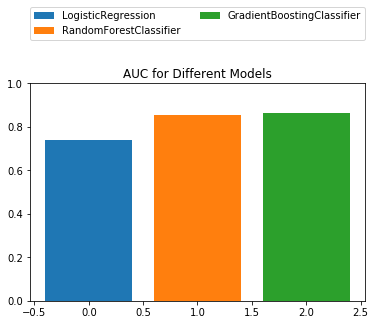

In [44]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['roc_auc'])
    plt.bar(i, model_results[model]['val']['roc_auc'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([0,1])
plt.title("AUC for Different Models")
plt.show()

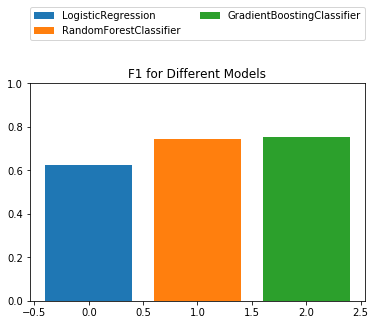

In [45]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['f1'])
    plt.bar(i, model_results[model]['val']['f1'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([0,1])
plt.title("F1 for Different Models")
plt.show()

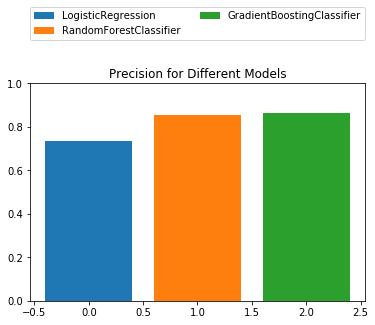

In [46]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['precision'])
    plt.bar(i, model_results[model]['val']['precision'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([0,1])
plt.title("Precision for Different Models")
plt.show()

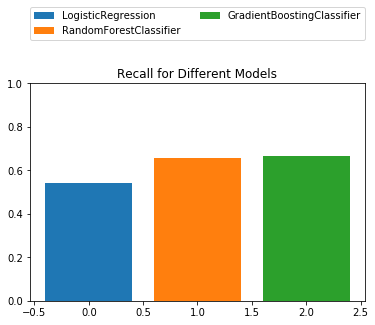

In [47]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['recall'])
    plt.bar(i, model_results[model]['val']['recall'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([0,1])
plt.title("Recall for Different Models")
plt.show()

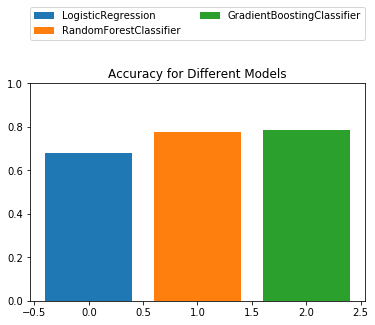

In [48]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['accuracy'])
    plt.bar(i, model_results[model]['val']['accuracy'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("Accuracy for Different Models")
plt.ylim([0,1])
plt.show()

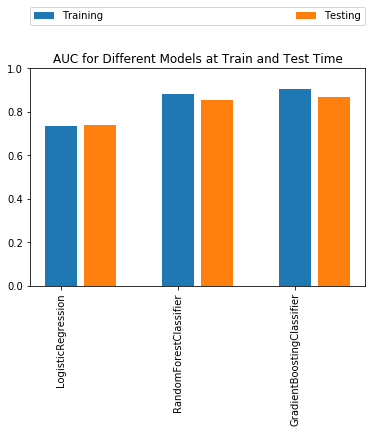

In [49]:
data_t = []
data_v = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['roc_auc'])
    data_v.append(model_results[model]['val']['roc_auc'])
plt.bar([3*i for i in range(len(models_plot))], data_t)
plt.bar([3*i+1 for i in range(len(models_plot))], data_v)
plt.xticks(np.arange(0,3*len(models_plot),3), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("AUC for Different Models at Train and Test Time")
plt.ylim([0,1])
plt.show()

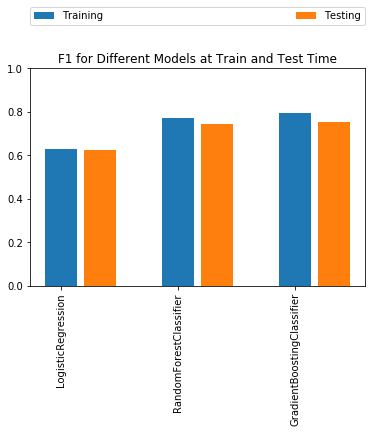

In [50]:
data_t = []
data_v = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['f1'])
    data_v.append(model_results[model]['val']['f1'])
plt.bar([3*i for i in range(len(models_plot))], data_t)
plt.bar([3*i+1 for i in range(len(models_plot))], data_v)
plt.xticks(np.arange(0,3*len(models_plot),3), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("F1 for Different Models at Train and Test Time")
plt.ylim([0,1])
plt.show()

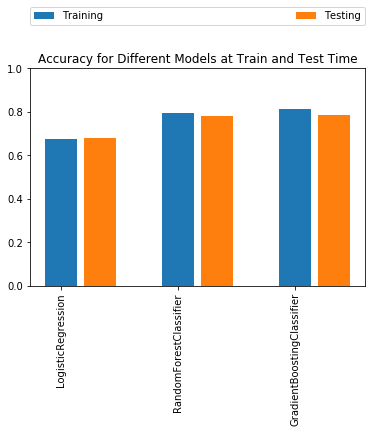

In [51]:
data_t = []
data_v = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['accuracy'])
    data_v.append(model_results[model]['val']['accuracy'])
plt.bar([3*i for i in range(len(models_plot))], data_t)
plt.bar([3*i+1 for i in range(len(models_plot))], data_v)
plt.xticks(np.arange(0,3*len(models_plot),3), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("Accuracy for Different Models at Train and Test Time")
plt.ylim([0,1])
plt.show()

In [52]:
metrics_ = pd.DataFrame()
table_models = [('Logistic Regression',lr1),('Random Forest',rfc),('Gradient Boosting',boost1)]
for (i,model) in enumerate(table_models):
    name = str(model[0])
    model = model[1]
    current = (model_results[model]['train']['accuracy'], model_results[model]['val']['accuracy'],
               model_results[model]['train']['roc_auc'], model_results[model]['val']['roc_auc'],
              model_results[model]['train']['f1'], model_results[model]['val']['f1'])
    metrics_ = pd.concat([metrics_,
                          pd.DataFrame([current],index=[name])])
metrics_.columns=['Training Accuracy','Test Accuracy','Training Auc','Test Auc','Training F1','Test F1']

In [53]:
metrics_


,Training Accuracy,Test Accuracy,Training Auc,Test Auc,Training F1,Test F1
Logistic Regression,0.673103,0.678293,0.734792,0.737852,0.630046,0.623171
Random Forest,0.794851,0.777720,0.880328,0.855416,0.772118,0.744464
Gradient Boosting,0.813355,0.785008,0.904030,0.865621,0.793349,0.752843


In [54]:
# load future
f_nominal_sample = pd.read_csv('samples/2018_nominal_samples_n1.csv')
f_gray_sample = pd.read_csv('samples/2018_gray_samples_n1.csv')
f_failure_sample = pd.read_csv('samples/2018_failure_samples_n1.csv')

#clean future
f_nominal_sample = f_nominal_sample.dropna(axis=0, thresh=20).dropna(axis=1)
f_failure_sample = f_failure_sample.dropna(axis=0, thresh=20).dropna(axis=1)
f_gray_sample    = f_gray_sample.dropna(axis=0, thresh=20).dropna(axis=1)
f_gray_sample.failure = 1
#f_nominal_sample = f_nominal_sample.sample(frac=(f_failure_sample.shape[0]+f_gray_sample.shape[0])/f_nominal_sample.shape[0])
f_nominal_sample = f_nominal_sample.sample(frac=(f_failure_sample.shape[0])/f_nominal_sample.shape[0])

#create test set
data_curr = pd.concat([f_nominal_sample, f_failure_sample])
data_curr = data_curr.sample(frac=1)
f_y_test = data_curr['failure']
f_x_test = data_curr[feature_columns]
f_x_test = scaler.transform(f_x_test)

In [55]:
for model in models:
    pred_test = model.predict_proba(f_x_test)[:,1]
    eval_f = helper.evaluation_metrics(pred_test, f_y_test)
    model_results[model]['future'] = eval_f

In [34]:
winsound.MessageBeep()

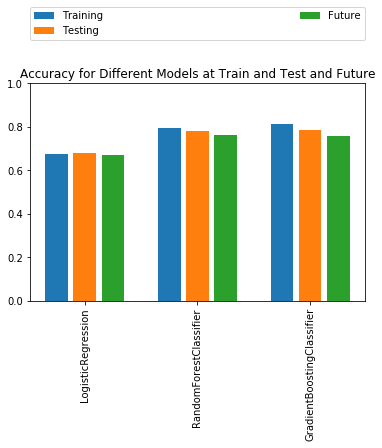

In [56]:
data_t = []
data_v = []
data_f = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['accuracy'])
    data_v.append(model_results[model]['val']['accuracy'])
    data_f.append(model_results[model]['future']['accuracy'])
plt.bar([4*i for i in range(len(models_plot))], data_t)
plt.bar([4*i+1 for i in range(len(models_plot))], data_v)
plt.bar([4*i+2 for i in range(len(models_plot))], data_f)
plt.xticks(np.arange(1,4*len(models_plot),4), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing","Future"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("Accuracy for Different Models at Train and Test and Future")
plt.ylim([0,1])
plt.show()

In [57]:
model_results[models[0]]['val']['accuracy'],model_results[models[0]]['future']['accuracy']

(0.6782925559604372, 0.6671794871794872)

In [58]:
model_results[models[1]]['val']['accuracy'],model_results[models[1]]['future']['accuracy']

(0.7777199375325351, 0.7615384615384615)

In [59]:
model_results[models[2]]['val']['accuracy'],model_results[models[2]]['future']['accuracy']

(0.7850078084331078, 0.7564102564102564)

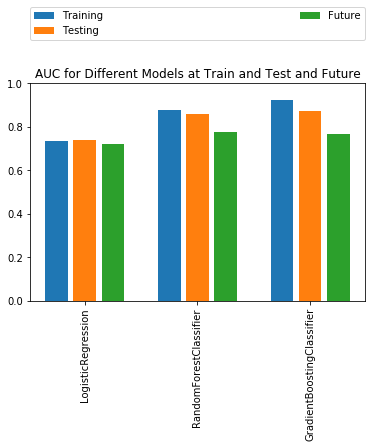

In [30]:
data_t = []
data_v = []
data_f = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['roc_auc'])
    data_v.append(model_results[model]['val']['roc_auc'])
    data_f.append(model_results[model]['future']['roc_auc'])
plt.bar([4*i for i in range(len(models_plot))], data_t)
plt.bar([4*i+1 for i in range(len(models_plot))], data_v)
plt.bar([4*i+2 for i in range(len(models_plot))], data_f)
plt.xticks(np.arange(1,4*len(models_plot),4), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing","Future"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("AUC for Different Models at Train and Test and Future")
plt.ylim([0,1])
plt.show()

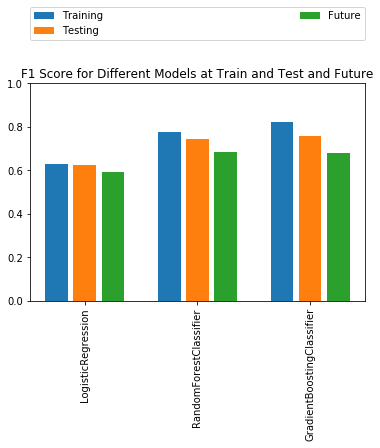

In [31]:
data_t = []
data_v = []
data_f = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['f1'])
    data_v.append(model_results[model]['val']['f1'])
    data_f.append(model_results[model]['future']['f1'])
plt.bar([4*i for i in range(len(models_plot))], data_t)
plt.bar([4*i+1 for i in range(len(models_plot))], data_v)
plt.bar([4*i+2 for i in range(len(models_plot))], data_f)
plt.xticks(np.arange(1,4*len(models_plot),4), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing","Future"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("F1 Score for Different Models at Train and Test and Future")
plt.ylim([0,1])
plt.show()

In [ ]:
metrics_ = pd.DataFrame()
table_models = [('Logistic Regression',lr1),('Random Forest',rfc),('Gradient Boosting',boost1)]
for (i,model) in enumerate(table_models):
    name = str(model[0])
    model = model[1]
    current = (model_results[model]['train']['accuracy'], model_results[model]['val']['accuracy'],
               model_results[model]['train']['roc_auc'], model_results[model]['val']['roc_auc'],
              model_results[model]['train']['f1'], model_results[model]['val']['f1'])
    metrics_ = pd.concat([metrics_,
                          pd.DataFrame([current],index=[name])])
metrics_.columns=['Training Accuracy','Test Accuracy','Training Auc','Test Auc','Training F1','Test F1']